### Module 24: 圖像風格遷移
* 演算法步驟:
1. 載入訓練好的的VGG
2. 隨機初始化生成image (產生noise Image)
3. 定義(1)風格損失函數，(2)內容損失函數，(3)總損失函數 = 風格損失函數+內容損失函數
4. 輸入 : 生成image, 風格image, 內容 image 至網路內
5. 優化生成image
* 損失函數定義: 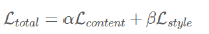
1. 內容損失函數 :選擇 VGG 網路的某一層 L ，去衡量內容照片與生成照片的 MSE<br>
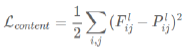
2.定義風格損失函數: 選擇 VGG 內多層的網路，計算被選到這幾層風格圖片以及生成圖片的 gram matrix<br>
將這些 gram matrix 做加總產生風格損失函數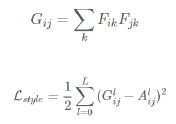
3.我們使用 backpropagation 去優化我們的生成圖片 
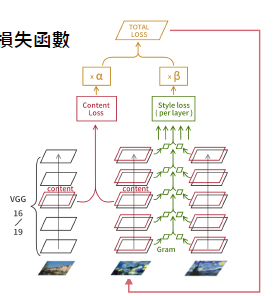

In [ ]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [ ]:
vgg = models.vgg19(pretrained=True).features  # pretrained=True : 已經訓練好的model
for param in vgg.parameters():
    param.requires_grad_(False)  # vgg parameter 不能微分(不能調整)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path)
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),   # image = size * size
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
style = load_image("default_style.jpg").to(device)
content  = load_image("default_content.jpg").to(device)

In [ ]:
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.set_title("Content-Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style-Image", fontsize = 20)
plt.show()

In [ ]:
print(vgg)

In [ ]:
def get_features(image, model, layers=None):
    if layers is None:   # style image 要抽哪一層
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '30': 'conv5_2', #content (content loss 用一層)
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [ ]:
style_weights = {'conv1_1': 1.5,
                 'conv2_1': 0.80,
                 'conv3_1': 0.25,
                 'conv4_1': 0.25,
                 'conv5_1': 0.25}
content_weight = 1e-2    # aphae
style_weight = 1e9       # beta

In [ ]:
show = 400
optimizer = optim.Adam([target], lr=0.01)
steps = 7000  
for i in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv5_2'] - content_features['conv5_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if  i % show == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()        
#ref: https://www.pluralsight.com/guides/artistic-neural-style-transfer-with-pytorch